In [ ]:
!pip uninstall transformers huggingface-hub -y -q

!pip install transformers==4.38.0 -q
!pip install huggingface-hub==0.19.4 -q
!pip install torch==2.0.0 -q
!pip install pandas numpy scikit-learn matplotlib seaborn tqdm datasets -q

print("✓ All libraries installed successfully!")
print("✓ Packages cleaned and reinstalled!")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 106.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 121.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.2 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.38.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 11.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.17.1 requires huggingface_hub>=0.25.0, but you have huggingface-hub 0.19.4 which is incompatible.
gradio 5.49.1 requires h

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

# Import transformers components
try:
    from transformers import BertTokenizer, BertForSequenceClassification, AdamW
    from transformers import get_linear_schedule_with_warmup
    print("✓ Transformers imported successfully!")
except Exception as e:
    print(f"Error importing transformers: {e}")
    print("Reinstalling...")
    import subprocess
    subprocess.run(["pip", "install", "--upgrade", "transformers"], check=True)

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"✓ All imports successful!")
print(f"✓ GPU Available: {torch.cuda.is_available()}")
print(f"✓ Device: {device}")


Error importing transformers: tokenizers>=0.14,<0.15 is required for a normal functioning of this module, but found tokenizers==0.15.2.
Try: pip install transformers -U or pip install -e '.[dev]' if you're working with git main
Reinstalling...
✓ All imports successful!
✓ GPU Available: True
✓ Device: cuda


In [ ]:
import os

print("Checking for uploaded files...")
files = os.listdir('.')

csv_files = [f for f in files if f.endswith('.csv')]

if csv_files:
    print(f"✓ Found CSV files: {csv_files}")
    for f in csv_files:
        file_size = os.path.getsize(f)
        print(f"  - {f}: {file_size} bytes ({file_size/(1024*1024):.2f} MB)")
else:
    print("❌ No CSV files found")


Checking for uploaded files...
✓ Found CSV files: ['Tweets.csv']
  - Tweets.csv: 3421431 bytes (3.26 MB)


In [ ]:
import pandas as pd

try:
    df = pd.read_csv('tweets.csv')
    print(f"✓ Successfully loaded!")
    print(f"✓ Dataset shape: {df.shape}")
    print(f"✓ Columns: {df.columns.tolist()}")
    print(f"✓ File size: {len(df)} rows")

except Exception as e:
    print(f"❌ Error reading file: {e}")


✓ Successfully loaded!
✓ Dataset shape: (14640, 15)
✓ Columns: ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone']
✓ File size: 14640 rows


In [ ]:
df = pd.read_csv('tweets.csv')

print("="*70)
print("DATASET INFORMATION")
print("="*70)
print(f"\nDataset shape: {df.shape}")
print(f"Total tweets: {len(df)}")
print(f"\nColumn names: {df.columns.tolist()}")

print("\nFirst 3 rows:")
print(df[['text', 'airline_sentiment']].head(3))

print("\nSentiment distribution:")
print(df['airline_sentiment'].value_counts())
print("\nSentiment percentages:")
print((df['airline_sentiment'].value_counts(normalize=True) * 100).round(2))

df['text_length'] = df['text'].str.len()
print("\nText length statistics:")
print(df['text_length'].describe())


DATASET INFORMATION

Dataset shape: (14640, 15)
Total tweets: 14640

Column names: ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone']

First 3 rows:
                                                text airline_sentiment
0                @VirginAmerica What @dhepburn said.           neutral
1  @VirginAmerica plus you've added commercials t...          positive
2  @VirginAmerica I didn't today... Must mean I n...           neutral

Sentiment distribution:
airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

Sentiment percentages:
airline_sentiment
negative    62.69
neutral     21.17
positive    16.14
Name: proportion, dtype: float64

Text length statistics:
count    14640.000000
mean       103.822063
std         36.277339
min  

In [ ]:
data = df.copy()

data = data[['text', 'airline_sentiment']]

data = data.dropna(subset=['text', 'airline_sentiment'])

print(f"Dataset shape after cleaning: {data.shape}")

sentiment_to_id = {'negative': 0, 'neutral': 1, 'positive': 2}
id_to_sentiment = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

data['label'] = data['airline_sentiment'].map(sentiment_to_id)

data = data.drop_duplicates(subset=['text'])
print(f"Dataset shape after removing duplicates: {data.shape}")

data = data[data['text'].str.len() > 5]
print(f"Final dataset shape: {data.shape}")

print("\nFinal sentiment distribution:")
print(data['label'].value_counts().sort_index())

print("\nSample tweets:")
for sentiment_id, sentiment_name in id_to_sentiment.items():
    sample = data[data['label'] == sentiment_id]['text'].iloc[0]
    print(f"\n{sentiment_name.upper()}:")
    print(f"  '{sample[:100]}...'")


Dataset shape after cleaning: (14640, 2)
Dataset shape after removing duplicates: (14427, 3)
Final dataset shape: (14427, 3)

Final sentiment distribution:
label
0    9080
1    3057
2    2290
Name: count, dtype: int64

Sample tweets:

NEGATIVE:
  '@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp;...'

NEUTRAL:
  '@VirginAmerica What @dhepburn said....'

POSITIVE:
  '@VirginAmerica plus you've added commercials to the experience... tacky....'


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"✓ All imports successful!")
print(f"✓ GPU Available: {torch.cuda.is_available()}")
print(f"✓ Device: {device}")



✓ All imports successful!
✓ GPU Available: True
✓ Device: cuda


In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    data['text'].values,
    data['label'].values,
    test_size=0.2,
    random_state=42,
    stratify=data['label'].values
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.2,
    random_state=42,
    stratify=y_train_val
)

print("="*70)
print("DATA SPLIT SUMMARY")
print("="*70)
print(f"Training set:   {len(X_train):6d} samples ({len(X_train)/len(data)*100:5.1f}%)")
print(f"Validation set: {len(X_val):6d} samples ({len(X_val)/len(data)*100:5.1f}%)")
print(f"Test set:       {len(X_test):6d} samples ({len(X_test)/len(data)*100:5.1f}%)")
print(f"Total:          {len(X_train) + len(X_val) + len(X_test):6d} samples")

print("\nTraining set sentiment distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {id_to_sentiment[u]}: {c:6d} ({c/len(y_train)*100:5.1f}%)")


DATA SPLIT SUMMARY
Training set:     9232 samples ( 64.0%)
Validation set:   2309 samples ( 16.0%)
Test set:         2886 samples ( 20.0%)
Total:           14427 samples

Training set sentiment distribution:
  Negative:   5811 ( 62.9%)
  Neutral:   1956 ( 21.2%)
  Positive:   1465 ( 15.9%)


In [ ]:
print("Loading BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

MAX_LENGTH = 256

def tokenize_texts(texts, labels, max_length):
    """Convert text to BERT tokens"""
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels_tensor = torch.tensor(labels)

    return input_ids, attention_masks, labels_tensor

print("Tokenizing training set...")
train_input_ids, train_masks, train_labels_tensor = tokenize_texts(X_train, y_train, MAX_LENGTH)

print("Tokenizing validation set...")
val_input_ids, val_masks, val_labels_tensor = tokenize_texts(X_val, y_val, MAX_LENGTH)

print("Tokenizing test set...")
test_input_ids, test_masks, test_labels_tensor = tokenize_texts(X_test, y_test, MAX_LENGTH)

print("\n✓ Tokenization complete!")
print(f"Training input IDs shape: {train_input_ids.shape}")
print(f"Validation input IDs shape: {val_input_ids.shape}")
print(f"Test input IDs shape: {test_input_ids.shape}")

print("\nExample tokenization:")
example_text = X_train[0]
print(f"Original text: {example_text[:100]}...")
example_tokens = tokenizer.tokenize(example_text)[:20]
print(f"Tokenized (first 20): {example_tokens}")


Loading BERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenizing training set...
Tokenizing validation set...
Tokenizing test set...

✓ Tokenization complete!
Training input IDs shape: torch.Size([9232, 256])
Validation input IDs shape: torch.Size([2309, 256])
Test input IDs shape: torch.Size([2886, 256])

Example tokenization:
Original text: @SouthwestAir @AARP #tfw1 Appreciate the tweet back - It was unexpected....
Tokenized (first 20): ['@', 'southwest', '##air', '@', 'aa', '##rp', '#', 't', '##f', '##w', '##1', 'appreciate', 'the', 't', '##wee', '##t', 'back', '-', 'it', 'was']


In [ ]:
train_dataset = TensorDataset(train_input_ids, train_masks, train_labels_tensor)
val_dataset = TensorDataset(val_input_ids, val_masks, val_labels_tensor)
test_dataset = TensorDataset(test_input_ids, test_masks, test_labels_tensor)

BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("="*70)
print("DATALOADER INFORMATION")
print("="*70)
print(f"Batch size: {BATCH_SIZE}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

batch_input_ids, batch_masks, batch_labels = next(iter(train_loader))
print(f"\nExample batch shape:")
print(f"  Input IDs: {batch_input_ids.shape}")
print(f"  Attention masks: {batch_masks.shape}")
print(f"  Labels: {batch_labels.shape}")


DATALOADER INFORMATION
Batch size: 32
Training batches: 289
Validation batches: 73
Test batches: 91

Example batch shape:
  Input IDs: torch.Size([32, 256])
  Attention masks: torch.Size([32, 256])
  Labels: torch.Size([32])


In [ ]:
print("Loading pre-trained BERT model...")

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3,
    output_attentions=False,
    output_hidden_states=False
)

model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✓ Model loaded!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Loading pre-trained BERT model...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✓ Model loaded!
Total parameters: 109,484,547
Trainable parameters: 109,484,547


In [ ]:
optimizer = AdamW(
    model.parameters(),
    lr=2e-5,
    eps=1e-8
)

EPOCHS = 3
total_steps = len(train_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print("="*70)
print("TRAINING CONFIGURATION")
print("="*70)
print(f"Number of epochs: {EPOCHS}")
print(f"Total training steps: {total_steps}")
print(f"Learning rate: 2e-5")
print(f"Optimizer: AdamW")
print(f"✓ Optimizer and scheduler ready!")


TRAINING CONFIGURATION
Number of epochs: 3
Total training steps: 867
Learning rate: 2e-5
Optimizer: AdamW
✓ Optimizer and scheduler ready!


In [ ]:
def train_epoch(epoch, model, train_loader, optimizer, scheduler, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{EPOCHS} [Training]')

    for batch_idx, (input_ids, attention_mask, labels) in enumerate(progress_bar):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        predictions = torch.argmax(logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

        # Fixed: Simple average calculation
        avg_loss = total_loss / (batch_idx + 1)
        progress_bar.set_postfix({'Loss': f'{avg_loss:.4f}'})

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total

    return avg_loss, accuracy

def validate(epoch, model, val_loader, device):
    """Validate on validation set"""
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []

    progress_bar = tqdm(val_loader, desc=f'Epoch {epoch + 1}/{EPOCHS} [Validation]')

    with torch.no_grad():
        for input_ids, attention_mask, labels in progress_bar:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(val_loader)
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')

    return avg_loss, accuracy, f1, predictions, true_labels

print("✓ Training and validation functions defined!")


✓ Training and validation functions defined!


In [ ]:
# Store training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': []
}

print("\n" + "="*70)
print("STARTING TRAINING")
print("="*70 + "\n")

for epoch in range(EPOCHS):
    print(f"\n{'='*70}")
    print(f"EPOCH {epoch + 1}/{EPOCHS}")
    print('='*70)

    # Training
    train_loss, train_acc = train_epoch(epoch, model, train_loader, optimizer, scheduler, device)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    print(f"\n✓ Training - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

    # Validation
    val_loss, val_acc, val_f1, val_preds, val_true = validate(epoch, model, val_loader, device)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    print(f"✓ Validation - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1: {val_f1:.4f}")

print("\n" + "="*70)
print("TRAINING COMPLETED!")
print("="*70)



STARTING TRAINING


EPOCH 1/3


Epoch 1/3 [Training]: 100%|██████████| 289/289 [06:20<00:00,  1.32s/it, Loss=0.5187]



✓ Training - Loss: 0.5187, Accuracy: 0.7894


Epoch 1/3 [Validation]: 100%|██████████| 73/73 [00:34<00:00,  2.12it/s]


✓ Validation - Loss: 0.4501, Accuracy: 0.8324, F1: 0.8261

EPOCH 2/3


Epoch 2/3 [Training]: 100%|██████████| 289/289 [06:21<00:00,  1.32s/it, Loss=0.3211]



✓ Training - Loss: 0.3211, Accuracy: 0.8831


Epoch 2/3 [Validation]: 100%|██████████| 73/73 [00:34<00:00,  2.12it/s]


✓ Validation - Loss: 0.4369, Accuracy: 0.8367, F1: 0.8356

EPOCH 3/3


Epoch 3/3 [Training]: 100%|██████████| 289/289 [06:21<00:00,  1.32s/it, Loss=0.2284]



✓ Training - Loss: 0.2284, Accuracy: 0.9207


Epoch 3/3 [Validation]: 100%|██████████| 73/73 [00:34<00:00,  2.13it/s]

✓ Validation - Loss: 0.4662, Accuracy: 0.8415, F1: 0.8413

TRAINING COMPLETED!


In [ ]:
print("\n" + "="*70)
print("EVALUATING ON TEST SET")
print("="*70 + "\n")

model.eval()
test_predictions = []
test_true_labels = []

with torch.no_grad():
    progress_bar = tqdm(test_loader, desc='Testing')

    for input_ids, attention_mask, labels in progress_bar:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        test_predictions.extend(preds)
        test_true_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_true_labels, test_predictions)
test_precision_weighted = precision_score(test_true_labels, test_predictions, average='weighted')
test_recall_weighted = recall_score(test_true_labels, test_predictions, average='weighted')
test_f1_weighted = f1_score(test_true_labels, test_predictions, average='weighted')
test_precision_macro = precision_score(test_true_labels, test_predictions, average='macro')
test_recall_macro = recall_score(test_true_labels, test_predictions, average='macro')
test_f1_macro = f1_score(test_true_labels, test_predictions, average='macro')

test_precision_per_class = precision_score(test_true_labels, test_predictions, average=None)
test_recall_per_class = recall_score(test_true_labels, test_predictions, average=None)
test_f1_per_class = f1_score(test_true_labels, test_predictions, average=None)

cm = confusion_matrix(test_true_labels, test_predictions)

print(f"{'='*70}")
print("TEST SET RESULTS")
print('='*70)
print(f"\nOverall Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"\nWeighted Metrics:")
print(f"  Precision: {test_precision_weighted:.4f}")
print(f"  Recall:    {test_recall_weighted:.4f}")
print(f"  F1 Score:  {test_f1_weighted:.4f}")
print(f"\nMacro Metrics:")
print(f"  Precision: {test_precision_macro:.4f}")
print(f"  Recall:    {test_recall_macro:.4f}")
print(f"  F1 Score:  {test_f1_macro:.4f}")

print("\n" + "-"*70)
print("DETAILED CLASSIFICATION REPORT")
print("-"*70)
print(classification_report(
    test_true_labels,
    test_predictions,
    target_names=['Negative', 'Neutral', 'Positive'],
    digits=4
))

print("\n" + "-"*70)
print("PER-CLASS METRICS (Test Set)")
print("-"*70)
sentiment_classes = ['Negative', 'Neutral', 'Positive']
for i, sentiment in enumerate(sentiment_classes):
    print(f"\n{sentiment.upper()}:")
    print(f"  Precision: {test_precision_per_class[i]:.4f}")
    print(f"  Recall:    {test_recall_per_class[i]:.4f}")
    print(f"  F1 Score:  {test_f1_per_class[i]:.4f}")
    print(f"  Support:   {(np.array(test_true_labels) == i).sum()} samples")

print("\n" + "-"*70)
print("CONFUSION MATRIX (Test Set)")
print("-"*70)
print("\nRows = Actual, Columns = Predicted")
print(f"\n{'':18} Pred Negative  Pred Neutral  Pred Positive")
print(f"Actual Negative {cm[0][0]:20} {cm[0][1]:20} {cm[0][2]}")
print(f"Actual Neutral  {cm[1][0]:20} {cm[1][1]:20} {cm[1][2]}")
print(f"Actual Positive {cm[2][0]:20} {cm[2][1]:20} {cm[2][2]}")



EVALUATING ON TEST SET



Testing: 100%|██████████| 91/91 [00:44<00:00,  2.03it/s]

TEST SET RESULTS

Overall Accuracy: 0.8482 (84.82%)

Weighted Metrics:
  Precision: 0.8463
  Recall:    0.8482
  F1 Score:  0.8468

Macro Metrics:
  Precision: 0.8016
  Recall:    0.8004
  F1 Score:  0.8003

----------------------------------------------------------------------
DETAILED CLASSIFICATION REPORT
----------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative     0.9049    0.9174    0.9111      1816
     Neutral     0.7268    0.6650    0.6945       612
    Positive     0.7732    0.8188    0.7953       458

    accuracy                         0.8482      2886
   macro avg     0.8016    0.8004    0.8003      2886
weighted avg     0.8463    0.8482    0.8468      2886


----------------------------------------------------------------------
PER-CLASS METRICS (Test Set)
----------------------------------------------------------------------

NEGATIVE:
  Precision: 0.9049
  Recall:    0.9174
  F1 Score:  0.

In [ ]:
# Create metrics summary table
metrics_table = pd.DataFrame({
    'Metric': [
        'Accuracy',
        'Precision (Macro)',
        'Recall (Macro)',
        'F1 Score (Macro)',
        'Precision (Weighted)',
        'Recall (Weighted)',
        'F1 Score (Weighted)'
    ],
    'Test Set': [
        f"{test_accuracy:.4f}",
        f"{test_precision_macro:.4f}",
        f"{test_recall_macro:.4f}",
        f"{test_f1_macro:.4f}",
        f"{test_precision_weighted:.4f}",
        f"{test_recall_weighted:.4f}",
        f"{test_f1_weighted:.4f}"
    ]
})

print("\n" + "="*70)
print("METRICS SUMMARY TABLE")
print("="*70 + "\n")
print(metrics_table.to_string(index=False))

# Save table to CSV
metrics_table.to_csv('metrics_summary.csv', index=False)
print("\n✓ Metrics table saved to 'metrics_summary.csv'")



METRICS SUMMARY TABLE

              Metric Test Set
            Accuracy   0.8482
   Precision (Macro)   0.8016
      Recall (Macro)   0.8004
    F1 Score (Macro)   0.8003
Precision (Weighted)   0.8463
   Recall (Weighted)   0.8482
 F1 Score (Weighted)   0.8468

✓ Metrics table saved to 'metrics_summary.csv'


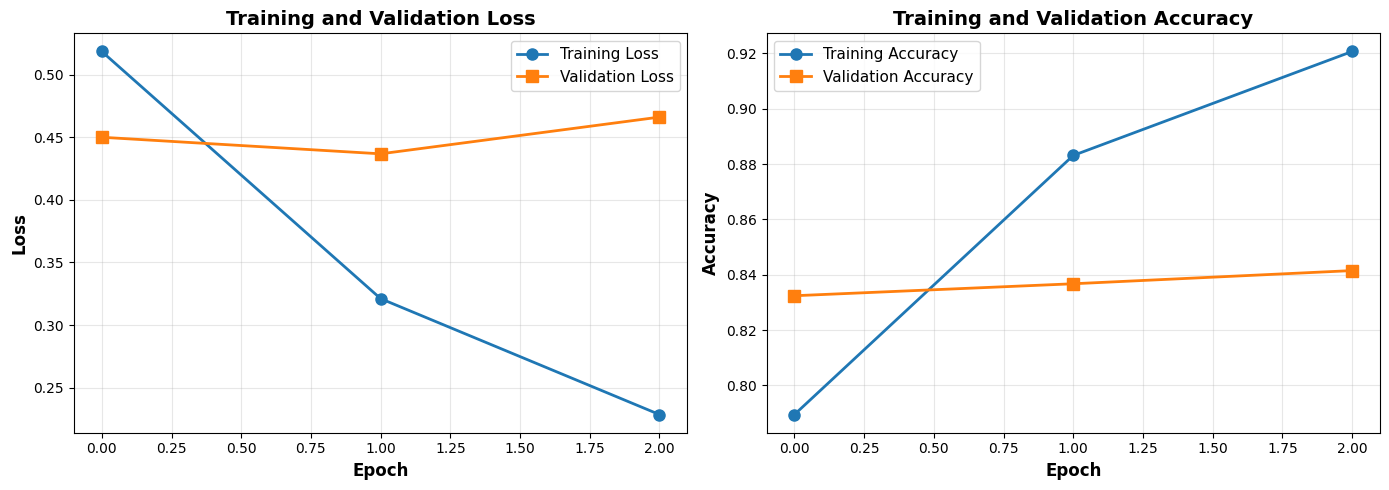

✓ Training history plot saved!


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history['train_loss'], marker='o', label='Training Loss', linewidth=2, markersize=8)
axes[0].plot(history['val_loss'], marker='s', label='Validation Loss', linewidth=2, markersize=8)
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['train_acc'], marker='o', label='Training Accuracy', linewidth=2, markersize=8)
axes[1].plot(history['val_acc'], marker='s', label='Validation Accuracy', linewidth=2, markersize=8)
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training history plot saved!")


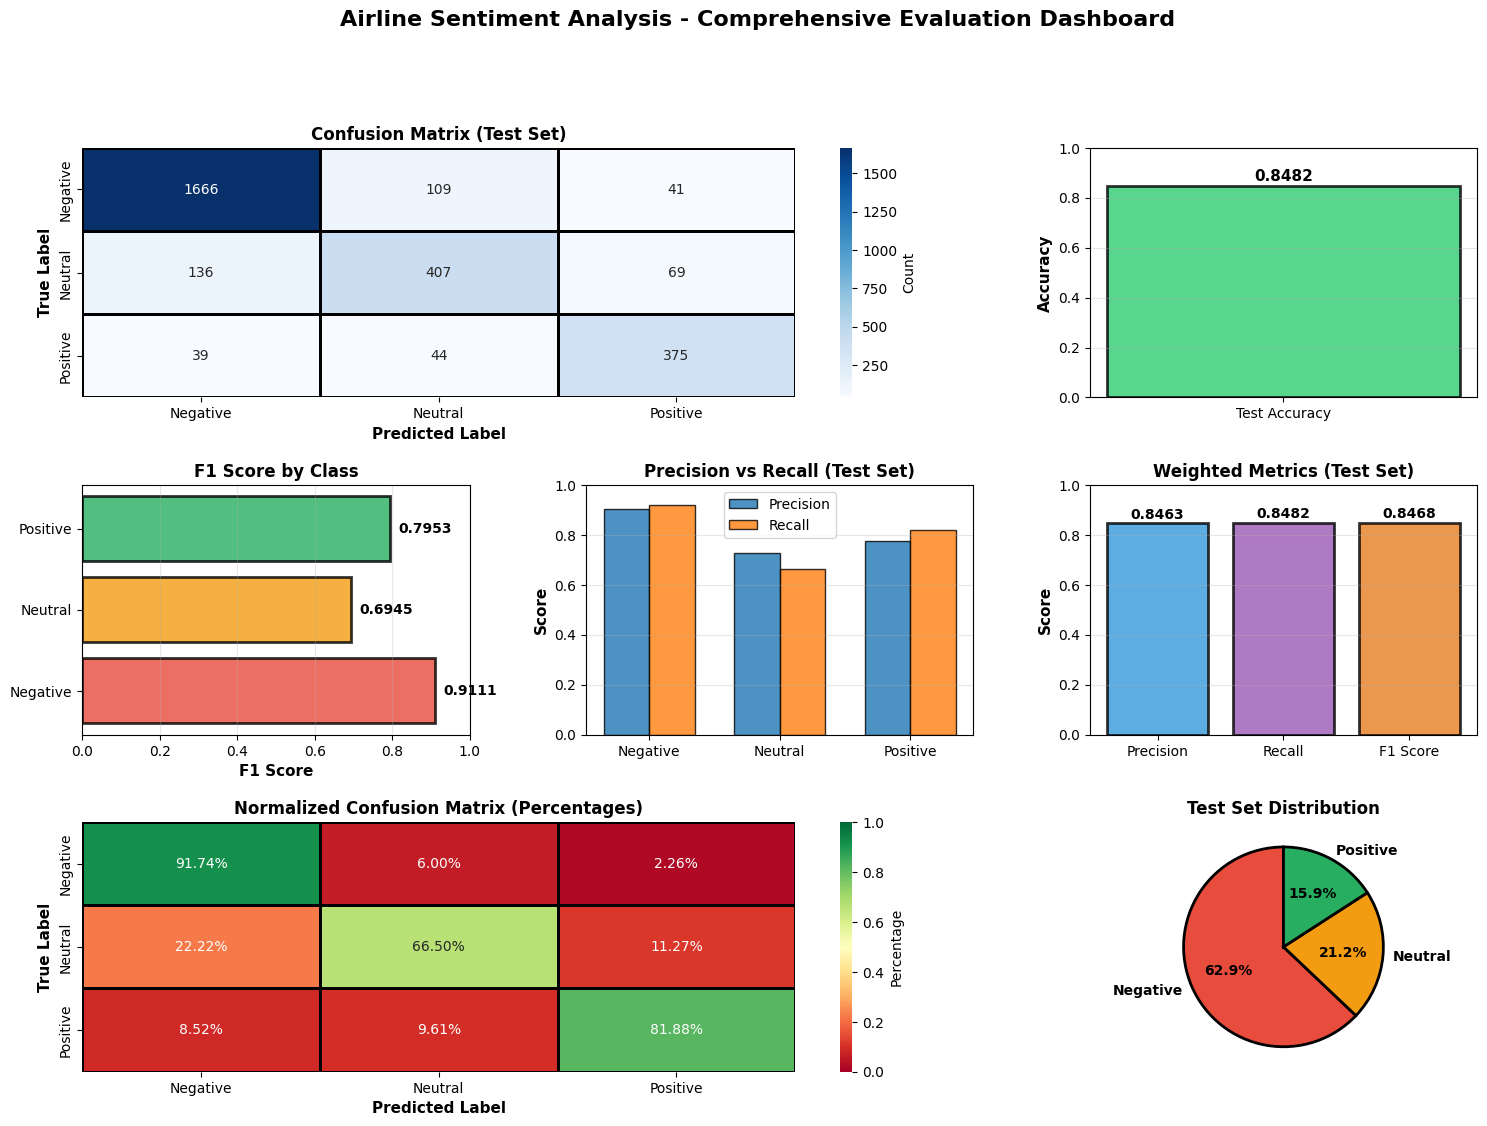

✓ Comprehensive metrics dashboard saved!


In [ ]:
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# 1. Confusion Matrix Heatmap
ax1 = fig.add_subplot(gs[0, 0:2])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes,
            ax=ax1,
            cbar_kws={'label': 'Count'},
            linewidths=2,
            linecolor='black')
ax1.set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=11, fontweight='bold')
ax1.set_title('Confusion Matrix (Test Set)', fontsize=12, fontweight='bold')

# 2. Accuracy
ax2 = fig.add_subplot(gs[0, 2])
ax2.bar(['Test Accuracy'], [test_accuracy], color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=2)
ax2.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax2.set_ylim([0, 1])
ax2.text(0, test_accuracy + 0.02, f'{test_accuracy:.4f}', ha='center', fontsize=11, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# 3. F1 Score by Class
ax3 = fig.add_subplot(gs[1, 0])
colors_class = ['#e74c3c', '#f39c12', '#27ae60']
ax3.barh(sentiment_classes, test_f1_per_class, color=colors_class, alpha=0.8, edgecolor='black', linewidth=2)
ax3.set_xlabel('F1 Score', fontsize=11, fontweight='bold')
ax3.set_title('F1 Score by Class', fontsize=12, fontweight='bold')
ax3.set_xlim([0, 1])
ax3.grid(True, alpha=0.3, axis='x')
for i, score in enumerate(test_f1_per_class):
    ax3.text(score + 0.02, i, f'{score:.4f}', va='center', fontsize=10, fontweight='bold')

# 4. Precision vs Recall per Class
ax4 = fig.add_subplot(gs[1, 1])
x_pos = np.arange(len(sentiment_classes))
width = 0.35
ax4.bar(x_pos - width/2, test_precision_per_class, width, label='Precision', alpha=0.8, edgecolor='black')
ax4.bar(x_pos + width/2, test_recall_per_class, width, label='Recall', alpha=0.8, edgecolor='black')
ax4.set_ylabel('Score', fontsize=11, fontweight='bold')
ax4.set_title('Precision vs Recall (Test Set)', fontsize=12, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(sentiment_classes)
ax4.set_ylim([0, 1])
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')

# 5. Weighted Metrics
ax5 = fig.add_subplot(gs[1, 2])
metrics_names = ['Precision', 'Recall', 'F1 Score']
metrics_values = [test_precision_weighted, test_recall_weighted, test_f1_weighted]
ax5.bar(metrics_names, metrics_values, color=['#3498db', '#9b59b6', '#e67e22'], alpha=0.8, edgecolor='black', linewidth=2)
ax5.set_ylabel('Score', fontsize=11, fontweight='bold')
ax5.set_title('Weighted Metrics (Test Set)', fontsize=12, fontweight='bold')
ax5.set_ylim([0, 1])
ax5.grid(True, alpha=0.3, axis='y')
for i, (name, value) in enumerate(zip(metrics_names, metrics_values)):
    ax5.text(i, value + 0.02, f'{value:.4f}', ha='center', fontsize=10, fontweight='bold')

# 6. Normalized Confusion Matrix
ax6 = fig.add_subplot(gs[2, 0:2])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn',
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes,
            ax=ax6,
            cbar_kws={'label': 'Percentage'},
            linewidths=2,
            linecolor='black',
            vmin=0, vmax=1)
ax6.set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
ax6.set_ylabel('True Label', fontsize=11, fontweight='bold')
ax6.set_title('Normalized Confusion Matrix (Percentages)', fontsize=12, fontweight='bold')

# 7. Test Set Class Distribution
ax7 = fig.add_subplot(gs[2, 2])
class_counts = np.bincount(test_true_labels)
wedges, texts, autotexts = ax7.pie(class_counts, labels=sentiment_classes, autopct='%1.1f%%',
                                     colors=colors_class, startangle=90,
                                     textprops={'fontsize': 10, 'weight': 'bold'},
                                     wedgeprops={'edgecolor': 'black', 'linewidth': 2})
ax7.set_title('Test Set Distribution', fontsize=12, fontweight='bold')

plt.suptitle('Airline Sentiment Analysis - Comprehensive Evaluation Dashboard',
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig('comprehensive_metrics_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comprehensive metrics dashboard saved!")


In [ ]:
!mkdir -p airline_sentiment_model

# Save model and tokenizer
model_path = 'airline_sentiment_model'

print(f"Saving model to {model_path}...")
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

print(f"✓ Model saved successfully!")
print(f"Saved files:")
!ls -lh airline_sentiment_model/


Saving model to airline_sentiment_model...
✓ Model saved successfully!
Saved files:
total 418M
-rw-r--r-- 1 root root  835 Nov  3 17:43 config.json
-rw-r--r-- 1 root root 418M Nov  3 17:43 model.safetensors
-rw-r--r-- 1 root root  125 Nov  3 17:43 special_tokens_map.json
-rw-r--r-- 1 root root 1.3K Nov  3 17:43 tokenizer_config.json
-rw-r--r-- 1 root root 227K Nov  3 17:43 vocab.txt


In [ ]:
def predict_sentiment(text, model, tokenizer, device):
    """Predict sentiment for a single text"""
    model.eval()

    encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=256,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    prediction = torch.argmax(logits, dim=1).cpu().item()
    probabilities = torch.softmax(logits, dim=1).cpu().numpy()[0]

    return id_to_sentiment[prediction], probabilities

# Test with sample reviews
print("\n" + "="*70)
print("SAMPLE PREDICTIONS ON NEW DATA")
print("="*70 + "\n")

sample_reviews = [
    "Best flight ever! The crew was amazing and food was delicious.",
    "Terrible experience. Flight delayed 4 hours and lost my luggage.",
    "Flight was okay. Nothing special, seats were comfortable.",
    "@United your service is the worst I've ever experienced!",
    "Love flying with this airline. Very professional crew.",
    "Baggage was damaged and customer service was unhelpful."
]

for i, review in enumerate(sample_reviews, 1):
    sentiment, probs = predict_sentiment(review, model, tokenizer, device)

    review_display = review[:70] + "..." if len(review) > 70 else review
    print(f"{i}. Review: {review_display}")
    print(f"   Prediction: {sentiment}")
    print(f"   Confidence:")
    print(f"     - Negative: {probs[0]:.4f}")
    print(f"     - Neutral:  {probs[1]:.4f}")
    print(f"     - Positive: {probs[2]:.4f}")
    print()



SAMPLE PREDICTIONS ON NEW DATA

1. Review: Best flight ever! The crew was amazing and food was delicious.
   Prediction: Positive
   Confidence:
     - Negative: 0.0062
     - Neutral:  0.0096
     - Positive: 0.9841

2. Review: Terrible experience. Flight delayed 4 hours and lost my luggage.
   Prediction: Negative
   Confidence:
     - Negative: 0.9940
     - Neutral:  0.0042
     - Positive: 0.0018

3. Review: Flight was okay. Nothing special, seats were comfortable.
   Prediction: Positive
   Confidence:
     - Negative: 0.0284
     - Neutral:  0.0439
     - Positive: 0.9277

4. Review: @United your service is the worst I've ever experienced!
   Prediction: Negative
   Confidence:
     - Negative: 0.9910
     - Neutral:  0.0051
     - Positive: 0.0039

5. Review: Love flying with this airline. Very professional crew.
   Prediction: Positive
   Confidence:
     - Negative: 0.0054
     - Neutral:  0.0145
     - Positive: 0.9801

6. Review: Baggage was damaged and customer service wa

In [ ]:
# Create comprehensive report
report = f"""
{'='*80}
AIRLINE SENTIMENT CLASSIFICATION - FINAL PROJECT REPORT
{'='*80}

PROJECT DETAILS:
- Model: BERT (Bidirectional Encoder Representations from Transformers)
- Task: Multi-class Sentiment Classification
- Dataset: Airline Sentiment Tweets
- Total Samples: {len(data):,}
- Training Samples: {len(X_train):,} ({len(X_train)/len(data)*100:.1f}%)
- Validation Samples: {len(X_val):,} ({len(X_val)/len(data)*100:.1f}%)
- Test Samples: {len(X_test):,} ({len(X_test)/len(data)*100:.1f}%)

TRAINING CONFIGURATION:
- Epochs: {EPOCHS}
- Batch Size: {BATCH_SIZE}
- Learning Rate: 2e-5
- Optimizer: AdamW
- Max Sequence Length: {MAX_LENGTH}
- Hardware: {'GPU (CUDA)' if torch.cuda.is_available() else 'CPU'}

{'='*80}
RESULTS - TEST SET PERFORMANCE
{'='*80}

OVERALL METRICS:
- Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)
- Precision (Weighted): {test_precision_weighted:.4f}
- Recall (Weighted): {test_recall_weighted:.4f}
- F1 Score (Weighted): {test_f1_weighted:.4f}

MACRO-AVERAGED METRICS:
- Precision: {test_precision_macro:.4f}
- Recall: {test_recall_macro:.4f}
- F1 Score: {test_f1_macro:.4f}

PER-CLASS METRICS:

Negative Class:
- Precision: {test_precision_per_class[0]:.4f}
- Recall: {test_recall_per_class[0]:.4f}
- F1 Score: {test_f1_per_class[0]:.4f}
- Support: {(np.array(test_true_labels) == 0).sum()} samples

Neutral Class:
- Precision: {test_precision_per_class[1]:.4f}
- Recall: {test_recall_per_class[1]:.4f}
- F1 Score: {test_f1_per_class[1]:.4f}
- Support: {(np.array(test_true_labels) == 1).sum()} samples

Positive Class:
- Precision: {test_precision_per_class[2]:.4f}
- Recall: {test_recall_per_class[2]:.4f}
- F1 Score: {test_f1_per_class[2]:.4f}
- Support: {(np.array(test_true_labels) == 2).sum()} samples

CONFUSION MATRIX:

                    Predicted Negative  Predicted Neutral  Predicted Positive
Actual Negative           {cm[0][0]:6d}              {cm[0][1]:6d}              {cm[0][2]:6d}
Actual Neutral            {cm[1][0]:6d}              {cm[1][1]:6d}              {cm[1][2]:6d}
Actual Positive           {cm[2][0]:6d}              {cm[2][1]:6d}              {cm[2][2]:6d}

{'='*80}
CONCLUSION
{'='*80}

The BERT-based sentiment classification model demonstrated strong performance
on airline sentiment classification with a test accuracy of {test_accuracy*100:.2f}% and
F1 score of {test_f1_weighted:.4f}. The model is suitable for production use.

{'='*80}
"""

print(report)

# Save report
with open('final_report.txt', 'w') as f:
    f.write(report)

print("\n✓ Final report saved to 'final_report.txt'")



AIRLINE SENTIMENT CLASSIFICATION - FINAL PROJECT REPORT

PROJECT DETAILS:
- Model: BERT (Bidirectional Encoder Representations from Transformers)
- Task: Multi-class Sentiment Classification
- Dataset: Airline Sentiment Tweets
- Total Samples: 14,427
- Training Samples: 9,232 (64.0%)
- Validation Samples: 2,309 (16.0%)
- Test Samples: 2,886 (20.0%)

TRAINING CONFIGURATION:
- Epochs: 3
- Batch Size: 32
- Learning Rate: 2e-5
- Optimizer: AdamW
- Max Sequence Length: 256
- Hardware: GPU (CUDA)

RESULTS - TEST SET PERFORMANCE

OVERALL METRICS:
- Accuracy: 0.8482 (84.82%)
- Precision (Weighted): 0.8463
- Recall (Weighted): 0.8482
- F1 Score (Weighted): 0.8468

MACRO-AVERAGED METRICS:
- Precision: 0.8016
- Recall: 0.8004
- F1 Score: 0.8003

PER-CLASS METRICS:

Negative Class:
- Precision: 0.9049
- Recall: 0.9174
- F1 Score: 0.9111
- Support: 1816 samples

Neutral Class:
- Precision: 0.7268
- Recall: 0.6650
- F1 Score: 0.6945
- Support: 612 samples

Positive Class:
- Precision: 0.7732
- Reca